# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy
import scipy

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import mplsoccer
from matplotlib.colors import LinearSegmentedColormap

# Loading Data

In [3]:
eventsDataLaLiga1920 = pd.read_csv('...\Data\matchwise_events_data_updated.csv',low_memory=False)

# Data Prep

In [5]:
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',150)

In [4]:
eventsDataLaLiga1920.head()

,match_id,id,index,period,timestamp,minute,second,possession,duration,type.id,...,home_team.home_team_name,away_team.away_team_id,away_team.away_team_name,jersey_number,started,subID,minMinute,maxMinute,maxMinsMatch,minsPlayed
0,303421,99d03ac6-bd7b-452a-91be-32e28f96bc1c,1,1,00:00.0,0,0,1,0.000000,35,...,Deportivo Alavés,217,Barcelona,NaN,NaN,NaN,NaN,94,94,NaN
1,303421,45e9a850-9a07-4266-8c05-66565e7ac83c,2,1,00:00.0,0,0,1,0.000000,35,...,Deportivo Alavés,217,Barcelona,NaN,NaN,NaN,NaN,94,94,NaN
2,303421,715a7900-5e3a-41f6-9870-44dc657ba2bc,3,1,00:00.0,0,0,1,0.000000,18,...,Deportivo Alavés,217,Barcelona,NaN,NaN,NaN,NaN,94,94,NaN
3,303421,9df4334c-c6e4-4457-97f2-8948375695c7,4,1,00:00.0,0,0,1,0.000000,18,...,Deportivo Alavés,217,Barcelona,NaN,NaN,NaN,NaN,94,94,NaN
4,303421,1a45cc07-8721-46a1-81eb-ac83d3e44b6d,5,1,00:00.6,0,0,2,1.235451,30,...,Deportivo Alavés,217,Barcelona,9.0,Yes,NaN,0.0,94,94,94.0


Getting Statsbomb Type IDs and Type Names

In [5]:
eventsDataLaLiga1920[['type.id','type.name']].drop_duplicates()

,type.id,type.name
0,35,Starting XI
2,18,Half Start
4,30,Pass
5,42,Ball Receipt*
8,43,Carry
39,17,Pressure
42,14,Dribble
43,4,Duel
87,22,Foul Committed
88,21,Foul Won


Extracting X and Y co-ordinates from the Location column

In [6]:
eventsDataLaLiga1920['startX'] = eventsDataLaLiga1920['location'].str.split(', ',expand=True)[0].str[1:].apply(pd.to_numeric)
eventsDataLaLiga1920['startY'] = eventsDataLaLiga1920['location'].str.split(', ',expand=True)[1].str[:-1].apply(pd.to_numeric)

Filtering out the Barcelona Data

In [7]:
barcaData = eventsDataLaLiga1920[eventsDataLaLiga1920['team.id']==217]

Removing data with no Player IDs

In [8]:
barcaData = barcaData[barcaData['player.id'].notna()]

Calculating Minutes played by the players

In [9]:
playerMins = barcaData.groupby(['player.id','player.name'])['minsPlayed'].agg(lambda x:x.drop_duplicates().sum())
playerMins = playerMins.reset_index()
playerTotMins = playerMins[playerMins['minsPlayed']>500]

# Visualization

Creating a Custom Color Map

In [10]:
customcmap2 = LinearSegmentedColormap.from_list('custom cmap', ['#0b090a','#161a1d','#660708','#a4161a','#ba181b','#e5383b'])

Plotting a Grid with Pitches with HeatMaps of all players who played for more than 500 minutes

Text(1, 0.5, '*Players who played a minimum of 500 minutes')

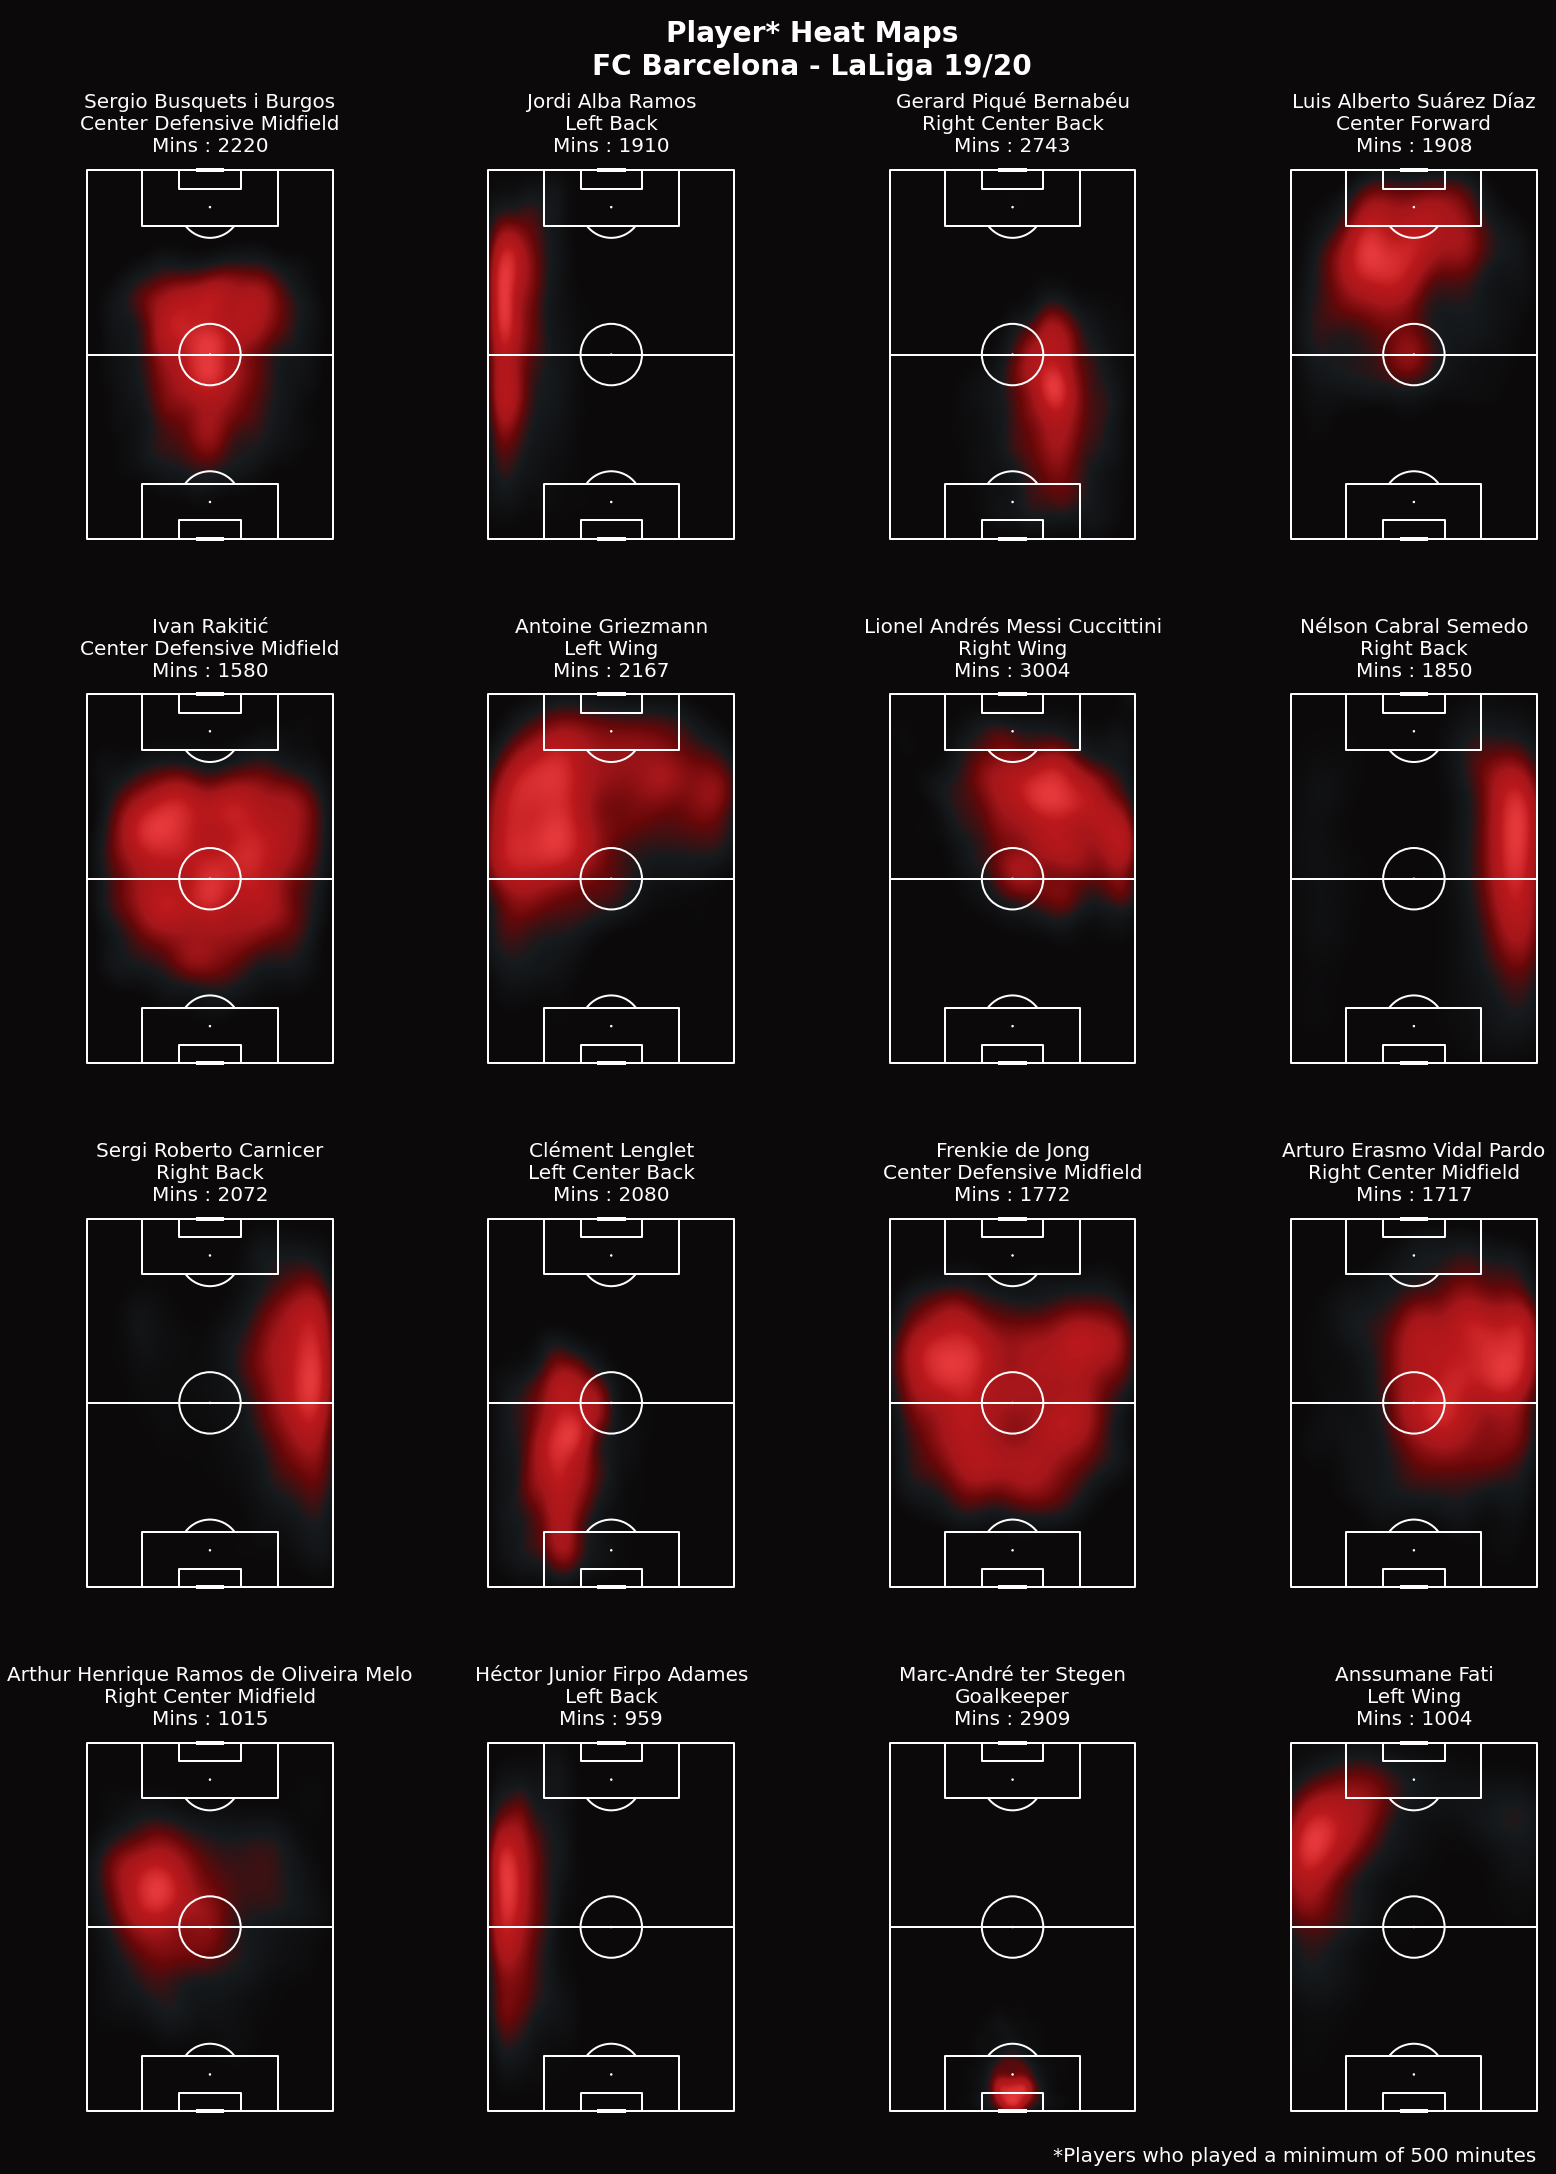

In [11]:
pitch = mplsoccer.VerticalPitch(pitch_type='statsbomb',line_zorder=1,pitch_color='#0b090a', line_color='white')
fig, axs = pitch.grid(nrows=4, ncols=4, axis=False,
                      figheight=30,
                      space=0.2, grid_height=0.91, grid_width=0.99,
                      title_height=0.06, endnote_height=0.01)
fig.set_facecolor('#0b090a')

playerIDs = playerTotMins['player.id'].unique()

for idx,ax in enumerate(axs['pitch'].flat):
    if idx < len(playerIDs):
        playerData = barcaData[barcaData['player.id']==playerIDs[idx]]
        
        kde = pitch.kdeplot(playerData['startX'],playerData['startY'],statistic='count',
                            ax=ax,cmap=customcmap2,shade=True,shade_lowest=False,
                            n_levels=400,line_width=3,alpha=1,zorder=0.99)
        
        playerName = playerData['player.name'].unique().item()
        position = playerData['position.name'].unique()[0]
        playerMins = playerData.dropna(subset=['minsPlayed'])\
                                            .drop_duplicates(subset=['match_id'])['minsPlayed'].sum().astype(int).item()
        ax.set_title(playerName + '\n' + position +'\nMins : ' + str(playerMins), fontsize = 20, color='white')
        
        
fig.suptitle('Player* Heat Maps\nFC Barcelona - LaLiga 19/20',
             ha='center',va='center',
             size=28,weight='bold',color='white')

axs['endnote'].text(1, 0.5, '*Players who played a minimum of 500 minutes',
                    color='white',fontsize=20, va='center', ha='right')